# Convolutional Variational Autoencoder for MNIST

## Imports

In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors
import torch.nn.functional as F
import time

#### Import utility functions

In [23]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [45]:
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 25
NUM_CLASSES = 10
set_deterministic
set_all_seeds(RANDOM_SEED)

Device: cpu


## Dataset

In [26]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0)
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [37]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

In [34]:
class VAEn(nn.Module):
    def __init__(self,n):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
            nn.Flatten(),
        )

        # Adjust these lines to change the latent space dimension to n
        self.z_mean = torch.nn.Linear(3136, n)  # Output dimension changed to n
        self.z_log_var = torch.nn.Linear(3136, n)  # Output dimension changed to n

        self.decoder = nn.Sequential(
                torch.nn.Linear(n, 3136),  # Input dimension changed to n
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # Adjust if necessary to match the desired output size
                nn.Sigmoid()
        )
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded


In [35]:
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

## Training

In [46]:
set_all_seeds(RANDOM_SEED)
dimensions = [20]
for dim in dimensions:
    model = VAEn(dim)
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

    log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                            optimizer=optimizer, device=DEVICE, 
                            train_loader=train_loader,
                            skip_epoch_stats=True,
                            logging_interval=50)
    torch.save(model.state_dict(), "model/VAE_LS" + str(dim))
    torch.save(optimizer.state_dict(), "model/VAE_LS" + str(dim) + "_optimizer")
    np.save("log_dict_LS" + str(dim) + ".npy", log_dict)

Epoch: 001/025 | Batch 0000/0234 | Loss: 154.0235
Epoch: 001/025 | Batch 0050/0234 | Loss: 57.2726
Epoch: 001/025 | Batch 0100/0234 | Loss: 51.6162
Epoch: 001/025 | Batch 0150/0234 | Loss: 49.7977
Epoch: 001/025 | Batch 0200/0234 | Loss: 45.2486
Time elapsed: 1.74 min
Epoch: 002/025 | Batch 0000/0234 | Loss: 40.6653
Epoch: 002/025 | Batch 0050/0234 | Loss: 35.8008
Epoch: 002/025 | Batch 0100/0234 | Loss: 33.7941
Epoch: 002/025 | Batch 0150/0234 | Loss: 32.7935
Epoch: 002/025 | Batch 0200/0234 | Loss: 32.8581
Time elapsed: 3.48 min
Epoch: 003/025 | Batch 0000/0234 | Loss: 33.4433
Epoch: 003/025 | Batch 0050/0234 | Loss: 31.9691
Epoch: 003/025 | Batch 0100/0234 | Loss: 32.2036
Epoch: 003/025 | Batch 0150/0234 | Loss: 30.6072
Epoch: 003/025 | Batch 0200/0234 | Loss: 30.3804
Time elapsed: 5.22 min
Epoch: 004/025 | Batch 0000/0234 | Loss: 31.7101
Epoch: 004/025 | Batch 0050/0234 | Loss: 30.3246
Epoch: 004/025 | Batch 0100/0234 | Loss: 30.5426
Epoch: 004/025 | Batch 0150/0234 | Loss: 31.4615

## Loss Function

In [39]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.set_title("Loss Function with Latent Space of Dimension " + str(dim))
    ax1.legend()

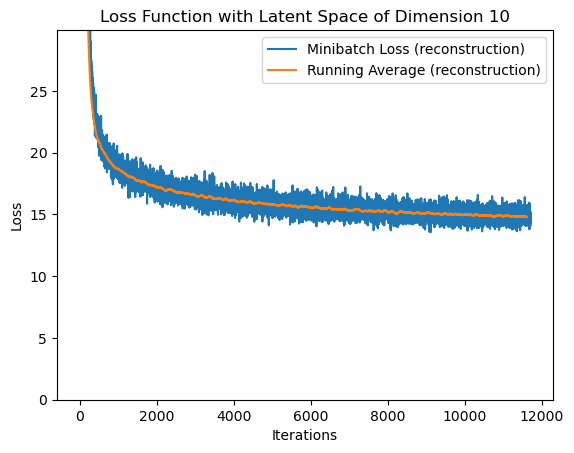

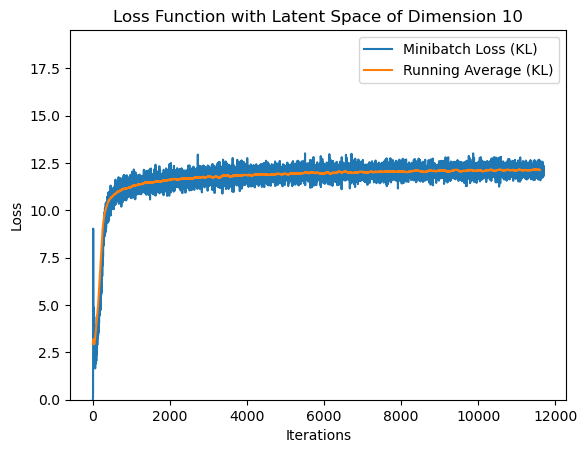

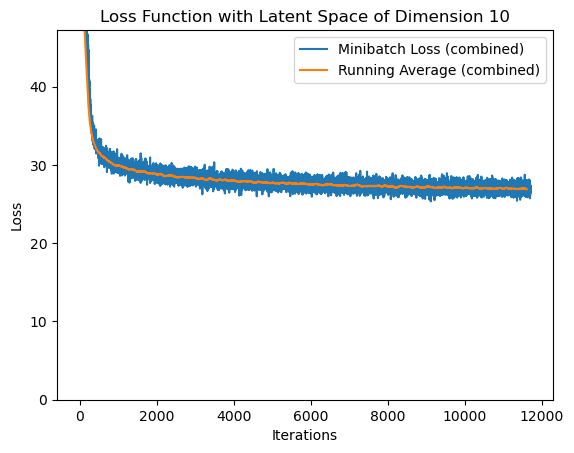

In [53]:
dimensions = [10]
for index, dim in enumerate(dimensions):
    log_dict = np.load(f"log_dict_LS{dim}.npy", allow_pickle=True).item()
    plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
    plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
    plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
    plt.show()
fig.savefig("VAE_Loss_Function_LSX" + ".png", dpi=400)

In [41]:
dimensions = [10]
for index, dim in enumerate(dimensions):
    log_dict = np.load(f"log_dict_LS{dim}.npy", allow_pickle=True).item()
    print("Dimension" + str(dim))
    print("Combined Loss", round(log_dict['train_combined_loss_per_batch'][-1],5))
    print("Reconstruction Loss", round(log_dict["train_reconstruction_loss_per_batch"][-1],5))
    print("KL Loss", round(log_dict['train_kl_loss_per_batch'][-1],5))
    plt.show()
fig.savefig("VAE_Loss_Function_LSX" + ".png", dpi=400)

Dimension10
Combined Loss 26.92206
Reconstruction Loss 14.77309
KL Loss 12.14898


## Visualizing Reconstruction Loss

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_generated_images(data_loader, model, device, unnormalizer=None, figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        features = features.to(device)
        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                _, _, _, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)
            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
    plt.tight_layout()
    return fig

# Assuming `dimensions` is a list of dimensions you want to iterate over
# and DEVICE, train_loader are defined.
for dim in dimensions:
    model = VAEn(dim).to(DEVICE)  # Ensure VAEn is properly defined beforehand
    model_state_dict = torch.load(f"model/VAE_LS20_25Epoch.pt", map_location=DEVICE)
    model.load_state_dict(model_state_dict)
    print("Dimension: " + str(dim))
    fig = plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')
    fig.savefig(f"Reconstruction_loss_ls{dim}.png")  # Save the figure
    plt.close(fig)  # Close the figure to free memory


Dimension: 20


## Visualizing Latent Space

import seaborn as sns
#2D Latent Space
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
        #Each is a minibatch
            features = features.to(device)
            targets = targets.to(device)
            
            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i #Vector. True where the digit is i
                    d[i].append(embedding[mask].to('cpu').numpy()) #Append all latent space to d[i]

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE)

plt.legend()
plt.show()

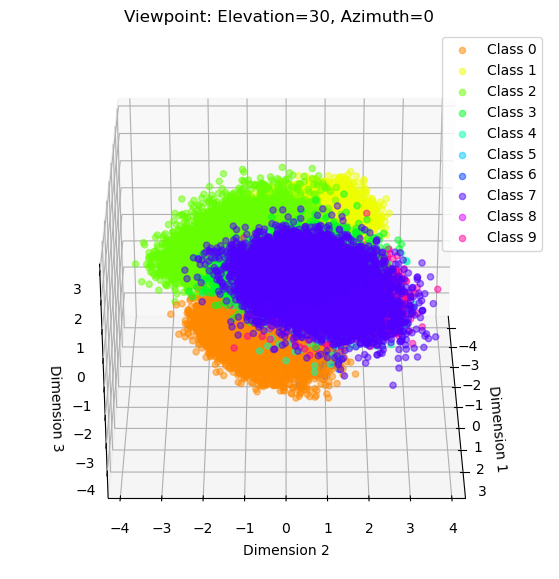

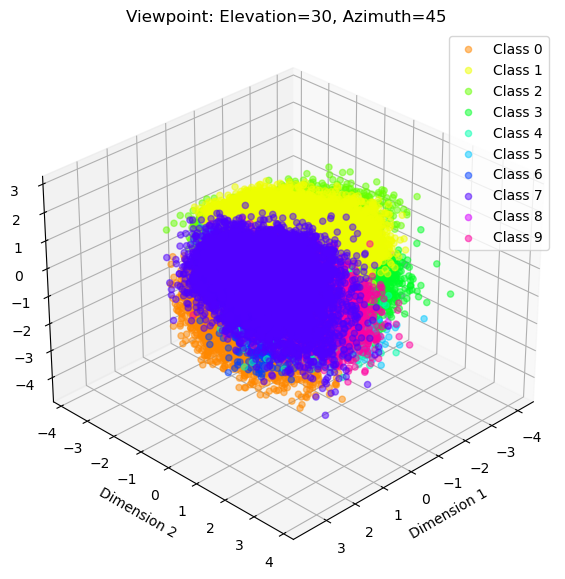

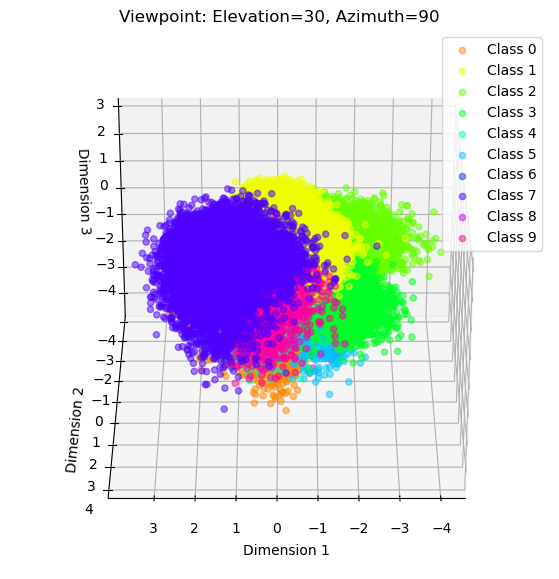

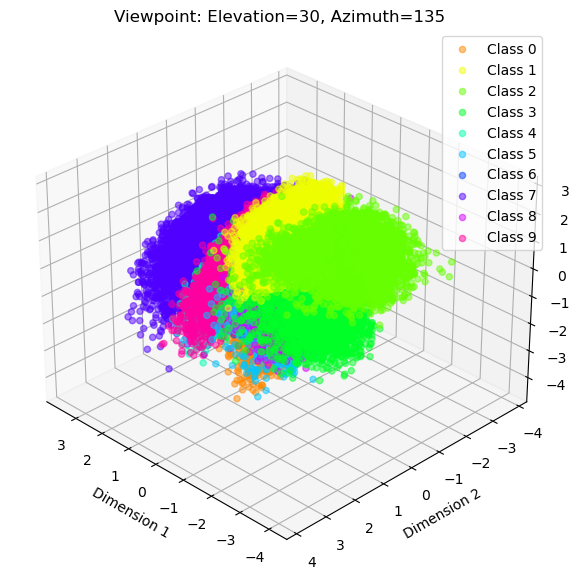

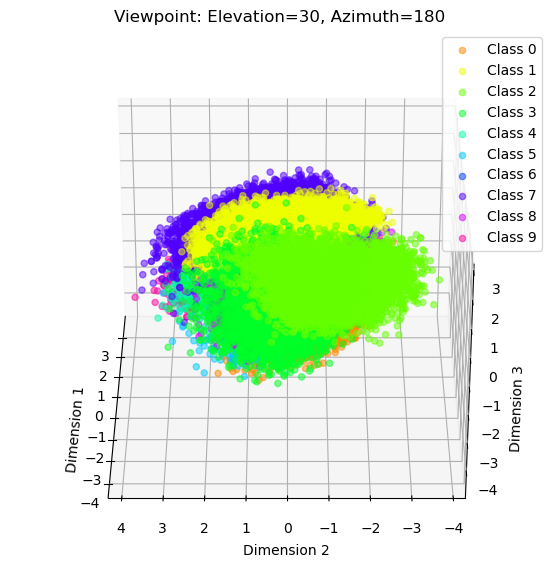

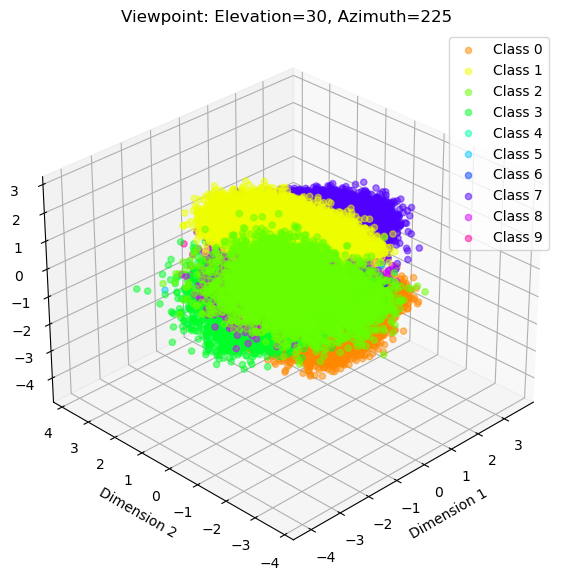

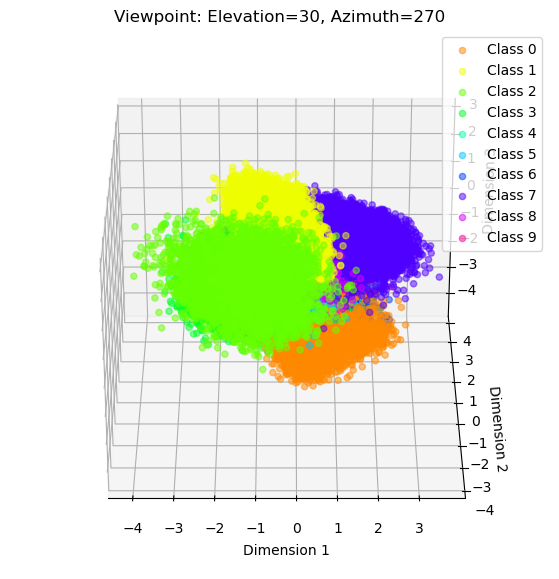

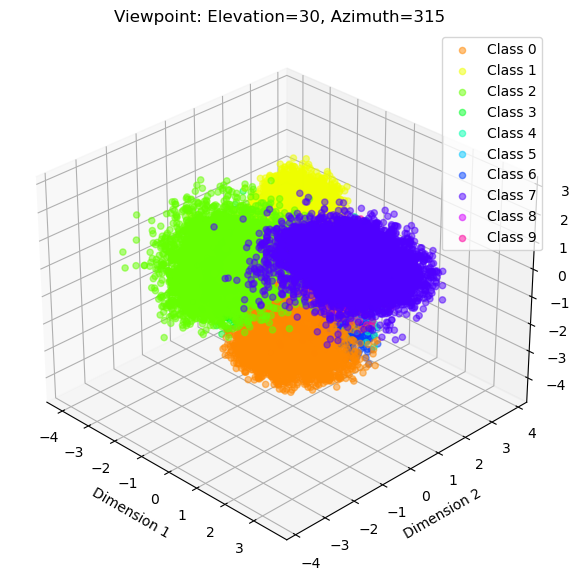

In [55]:
def plot_latent_space_with_labels_3d(num_classes, data_loader, encoding_fn, device, angles):
    d = {i: [] for i in range(num_classes)}
    
    # Collect embeddings
    with torch.no_grad():
        for _, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            
            embedding = encoding_fn(features)
            
            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())
                    
    # Concatenate embeddings for each class once, before looping over angles
    concatenated_d = {i: np.concatenate(d[i], axis=0) if len(d[i]) > 0 else np.array([]) 
                      for i in range(num_classes)}
    
    colors = list(sns.color_palette("hsv", num_classes))
    
    img_number = 0
    for elev, azim in angles:
        img_number += 1
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        for i in range(num_classes):
            # Check if we have data for the current class to avoid the indexing error
            if concatenated_d[i].size > 0:
                # Ensuring embeddings are 3-dimensional
                if concatenated_d[i].shape[1] < 3:
                    raise ValueError("Embeddings must be at least 3-dimensional for 3D plotting.")
                
                ax.scatter(
                    concatenated_d[i][:, 0], concatenated_d[i][:, 1], concatenated_d[i][:, 2],
                    color=colors[i],
                    label=f'Class {i}',
                    alpha=0.5)
        
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        ax.view_init(elev=elev, azim=azim)
        plt.legend()
        plt.title(f"Viewpoint: Elevation={elev}, Azimuth={azim}")
        plt.show()
        fig.savefig("VAE_2D_Angle" + str(img_number) +".png", dpi=400)

angles = [(30, azim) for azim in range(0, 360, 45)]
plot_latent_space_with_labels_3d(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE,
    angles=angles
)


## Random Sampling from Latent Space

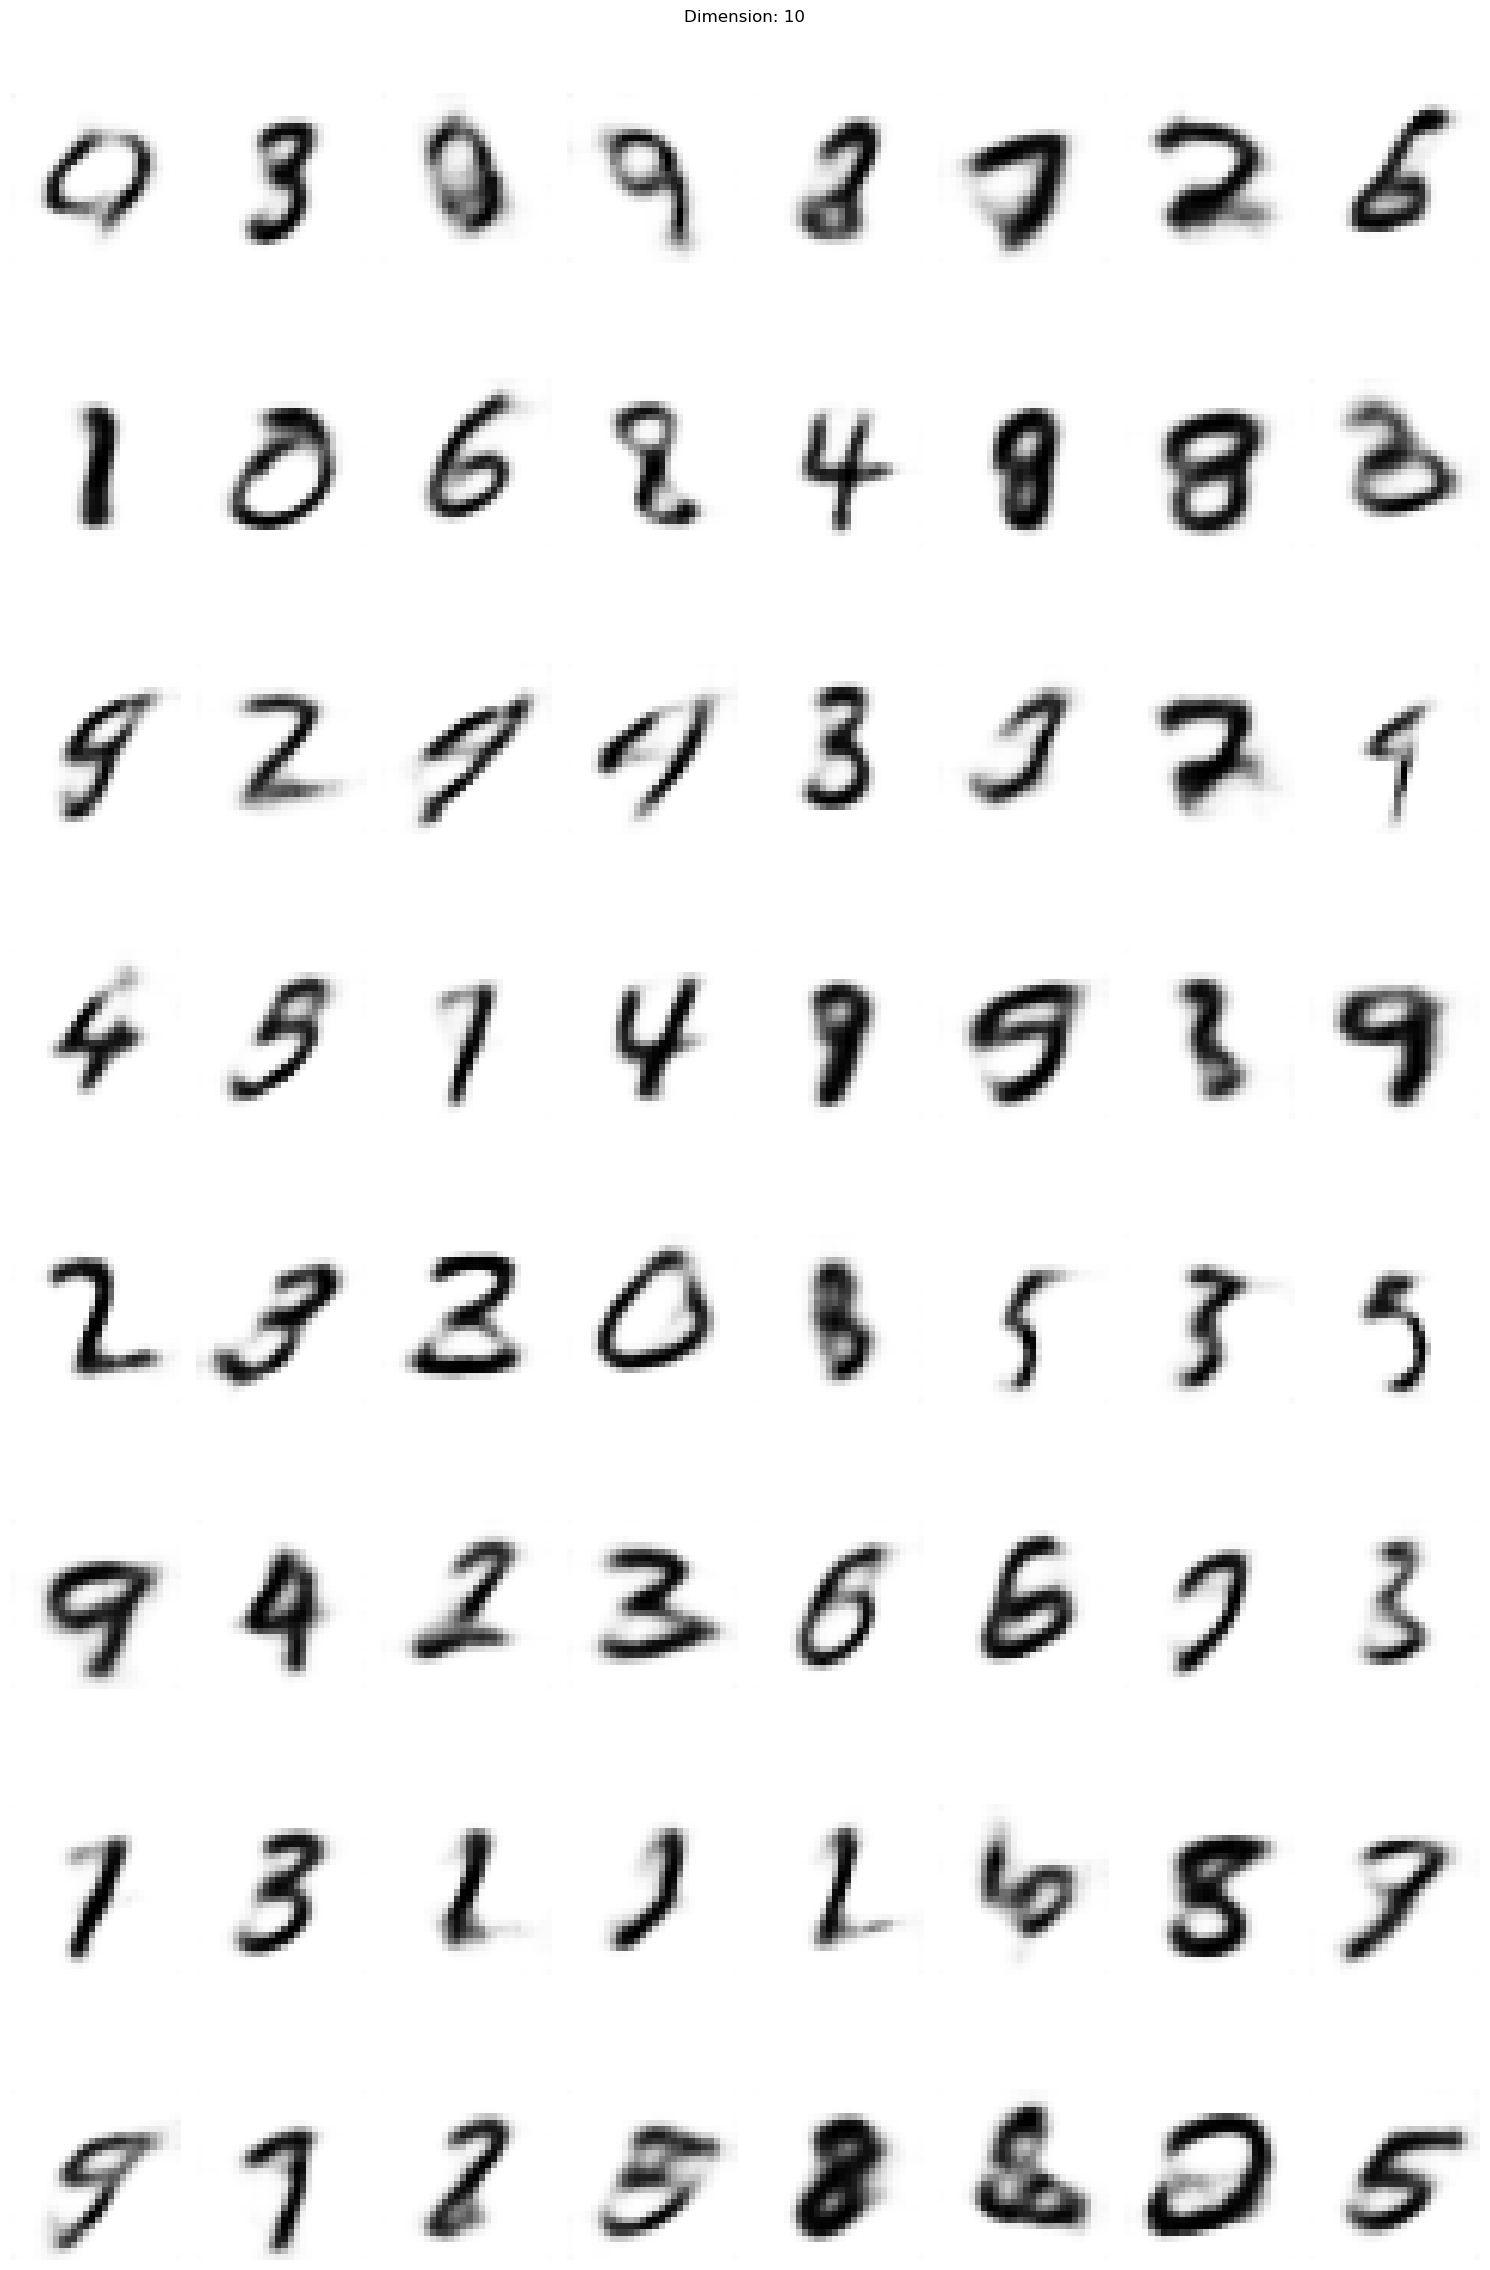

In [185]:
import torch
import numpy as np
import matplotlib.pyplot as plt

dimensions = [10]
n = 64  # Total number of samples per dimension
samples_per_row = 8  # Images per row

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

for dim in dimensions:
    model = VAEn(dim).to(DEVICE)  # Make sure VAEn is defined and ready to be instantiated
    model_state_dict = torch.load(f"model/VAE_LS{dim}.pt", map_location=DEVICE)
    model.load_state_dict(model_state_dict)
    model.eval()  # Set the model to evaluation mode
    
    # Number of rows needed to display 'n' images, with 'samples_per_row' images per row
    nrows = n // samples_per_row + (n % samples_per_row > 0)
    
    fig, axes = plt.subplots(nrows, samples_per_row, figsize=(15, 3 * nrows))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Generate and process samples
    for i in range(n):
        mean = np.zeros(dim, dtype=np.float32)
        covariance = np.identity(dim, dtype=np.float32)
        sample = np.random.multivariate_normal(mean, covariance, 1)  # Generate one sample
        sample_tensor = torch.tensor(sample, dtype=torch.float32).to(DEVICE)
        
        with torch.no_grad():
            new_image = model.decoder(sample_tensor).squeeze()  # Adjust as necessary for your model
        
        # Plot the image on its respective subplot
        ax = axes[i]
        ax.imshow(new_image.cpu().numpy(), cmap='binary')
        ax.axis('off')  # Hide axes for cleaner visualization
    
    # Hide any unused subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')
        
    plt.suptitle(f'Dimension: {dim}')
    plt.tight_layout()
    plt.show()
    fig.savefig("Random Samples from LS" + str(dim) +".png", dpi=400)
